# Linear Regression Modeling of Medical Insurance

This project focuses on how different characteristics relate to the total medical cost. 

In [42]:
#Loading Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [43]:
import warnings
warnings.filterwarnings("ignore")

In [44]:
#Importing Modules
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [45]:
insurance = pd.read_csv('insurance.csv') #Loads data

In [46]:
print(insurance.shape)
print(insurance.head())
print(insurance.dtypes)

(1338, 7)
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object


So we have a fairly small amount of characteristic columns and only ~1300 rows to look at. 

We have 4 numerical columns:
- Age
- BMI
- Children
- Charges

And 3 categorical columns:
- Sex
- Smoker
- Region

First let's look at values in the categorical columns

## Identifying Patterns
### Scatter plots

In [47]:
cat_columns = insurance.select_dtypes(include = 'object').columns
num_columns = insurance.drop(cat_columns, axis = 1)

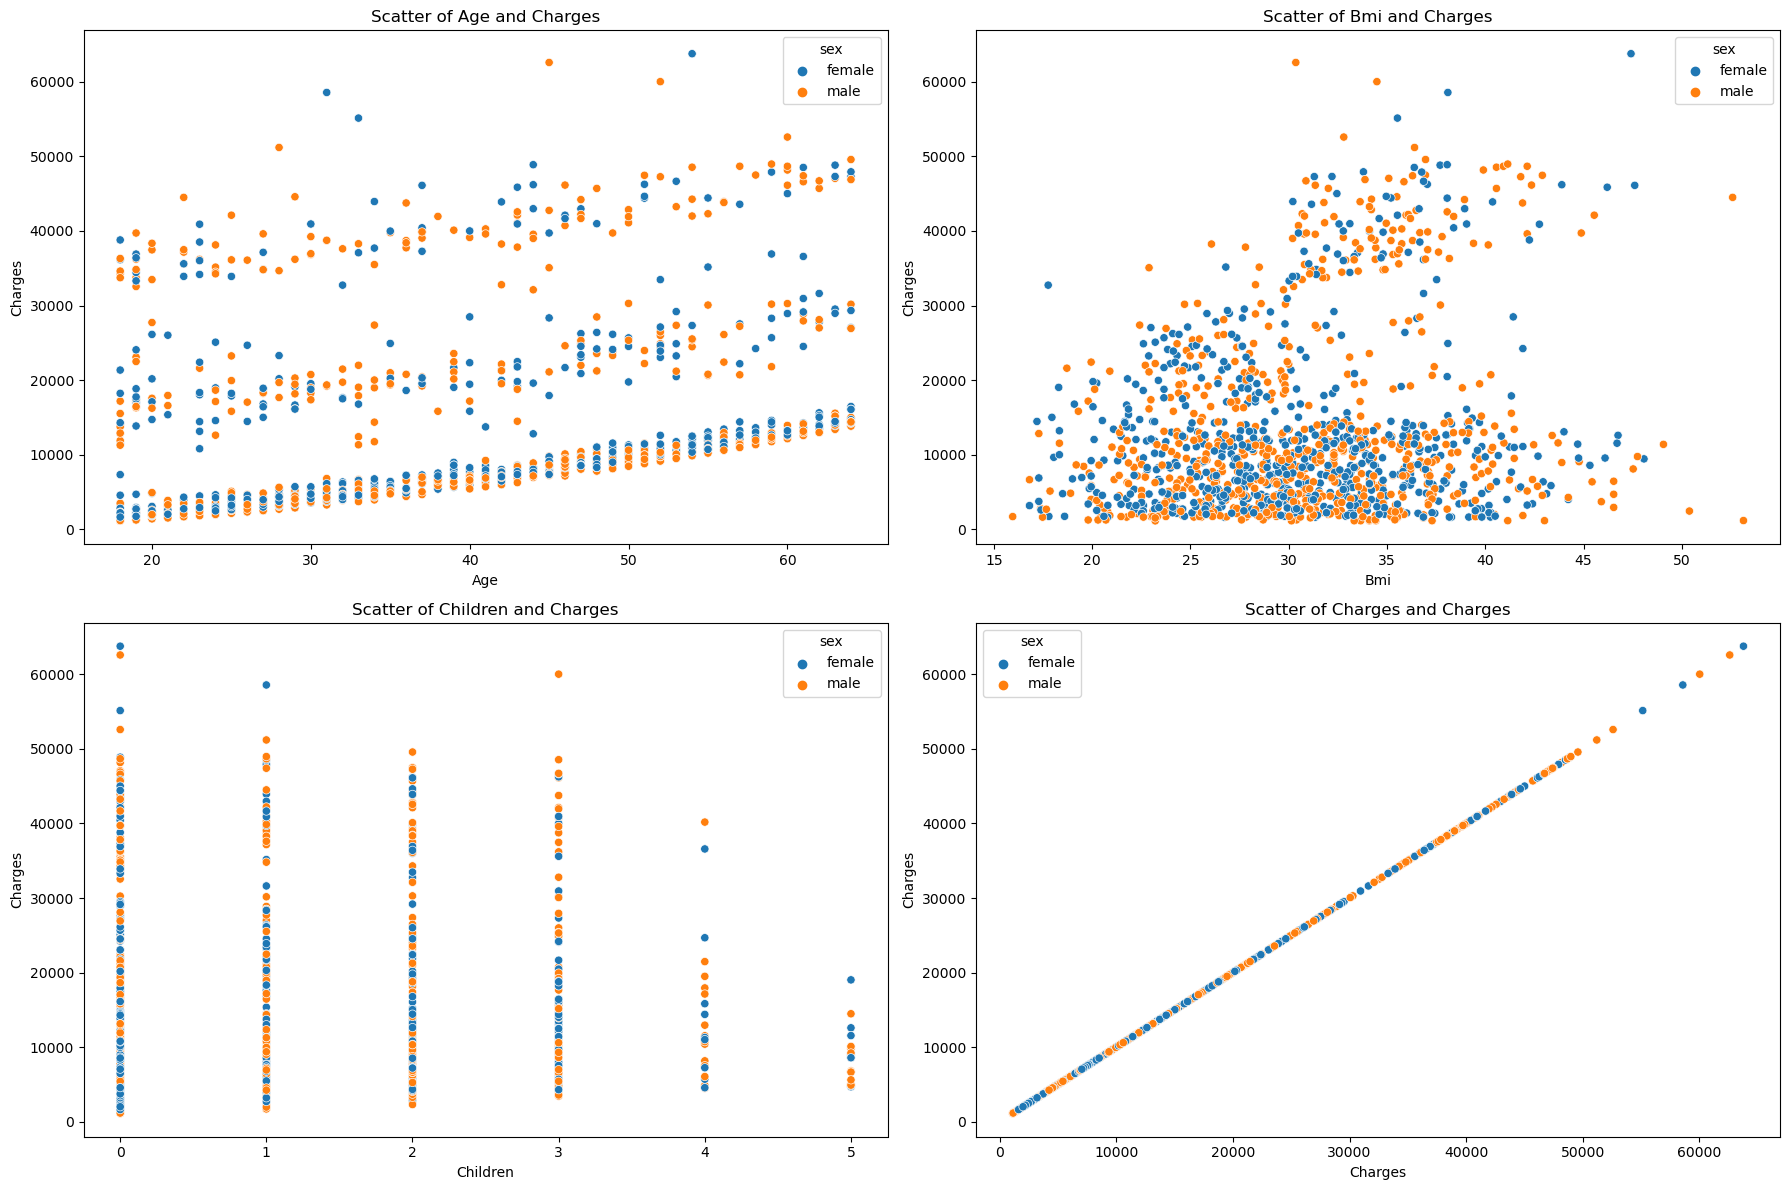

In [48]:
#Plotting by Sex
fig = plt.figure(figsize = (18,12))
for i, column in enumerate(num_columns):
    ax = fig.add_subplot(2,2,i+1)
    sns.scatterplot(insurance[column], insurance['charges'],
              hue = insurance['sex'])
    plt.xlabel(f"{column.title()}")
    plt.ylabel('Charges')
    plt.title(f"Scatter of {column.title()} and Charges")
plt.tight_layout()
plt.show()

It seems that possibly male patients have higher charges, but that opinion isn't too supported by the plots here. 

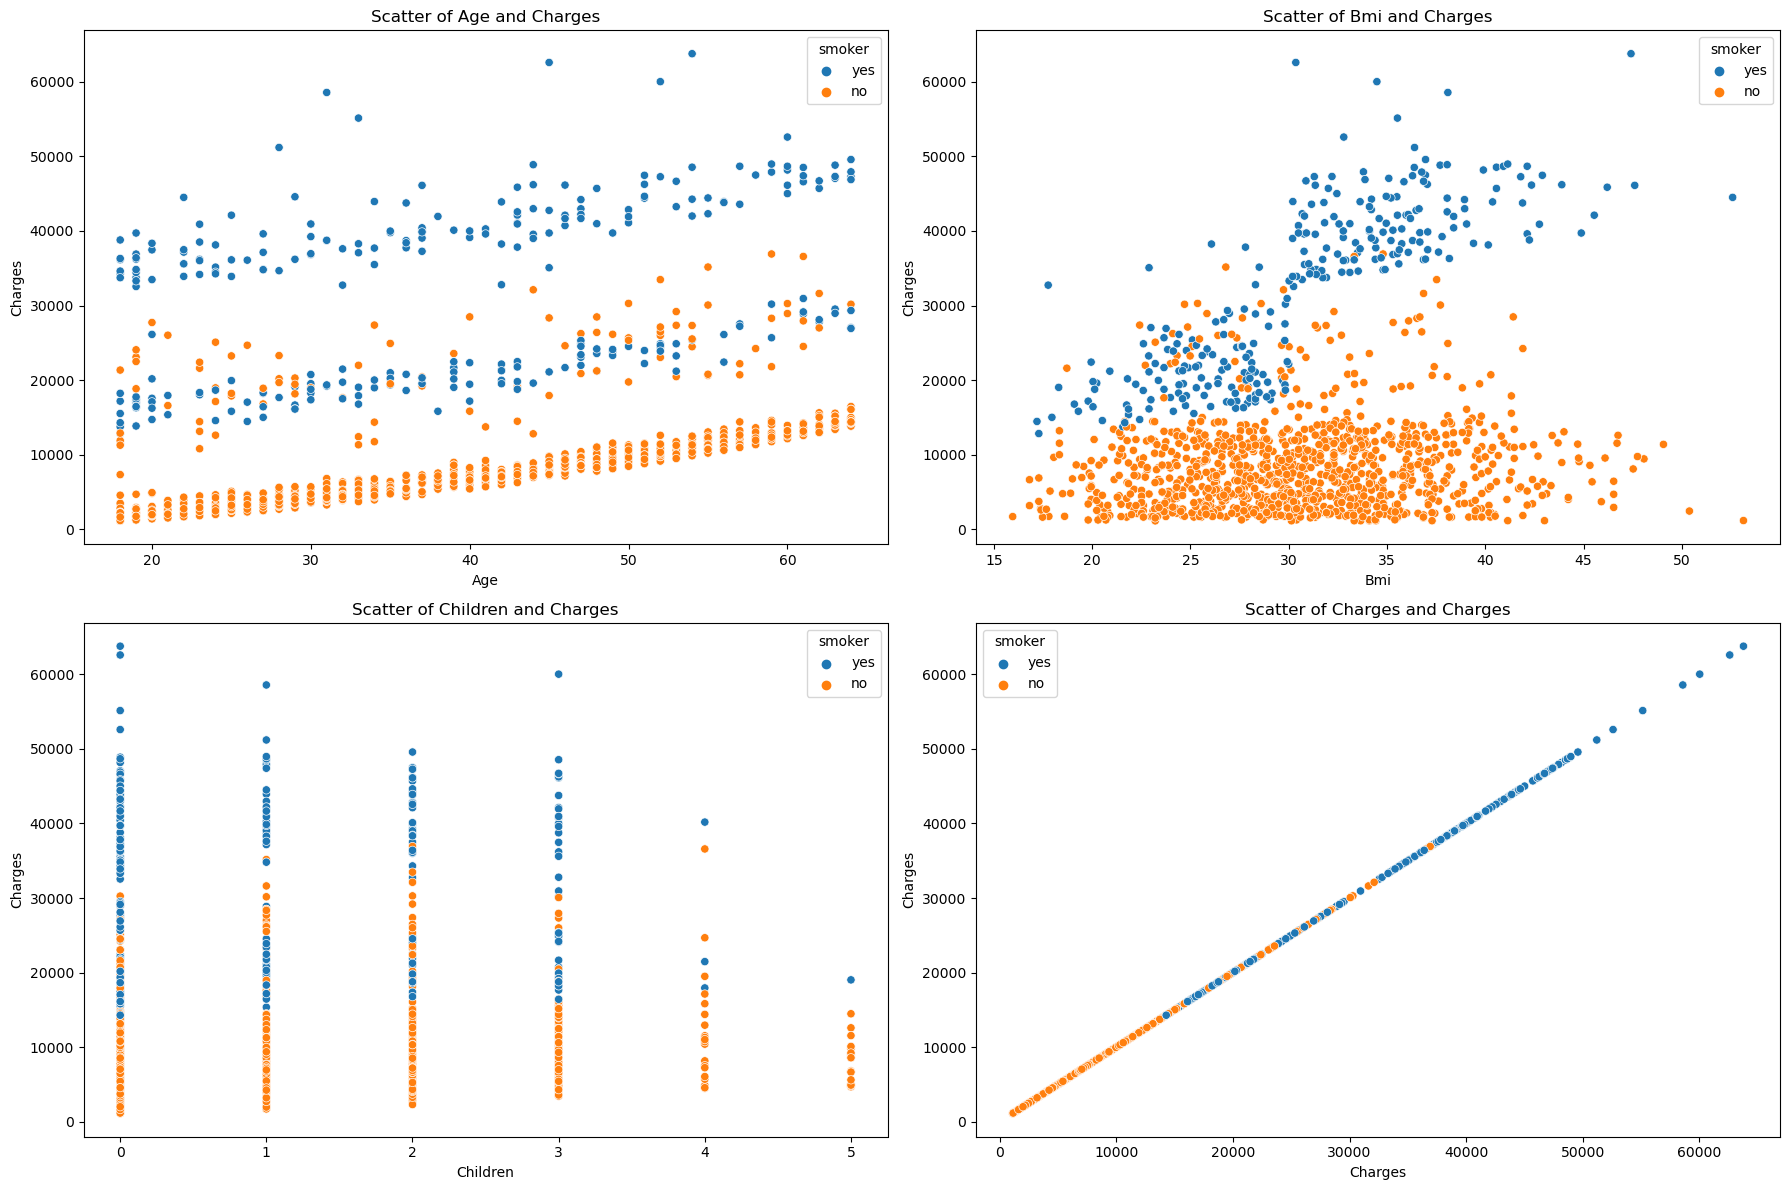

In [49]:
fig = plt.figure(figsize = (18,12))
for i, column in enumerate(num_columns):
    ax = fig.add_subplot(2,2,i+1)
    sns.scatterplot(insurance[column], insurance['charges'],
              hue = insurance['smoker'])
    plt.xlabel(f"{column.title()}")
    plt.ylabel('Charges')
    plt.title(f"Scatter of {column.title()} and Charges")
plt.tight_layout()
plt.show()

These charts are striking, almost every smoker present in the plots have higher insurance charges than non-smokers. In every column!

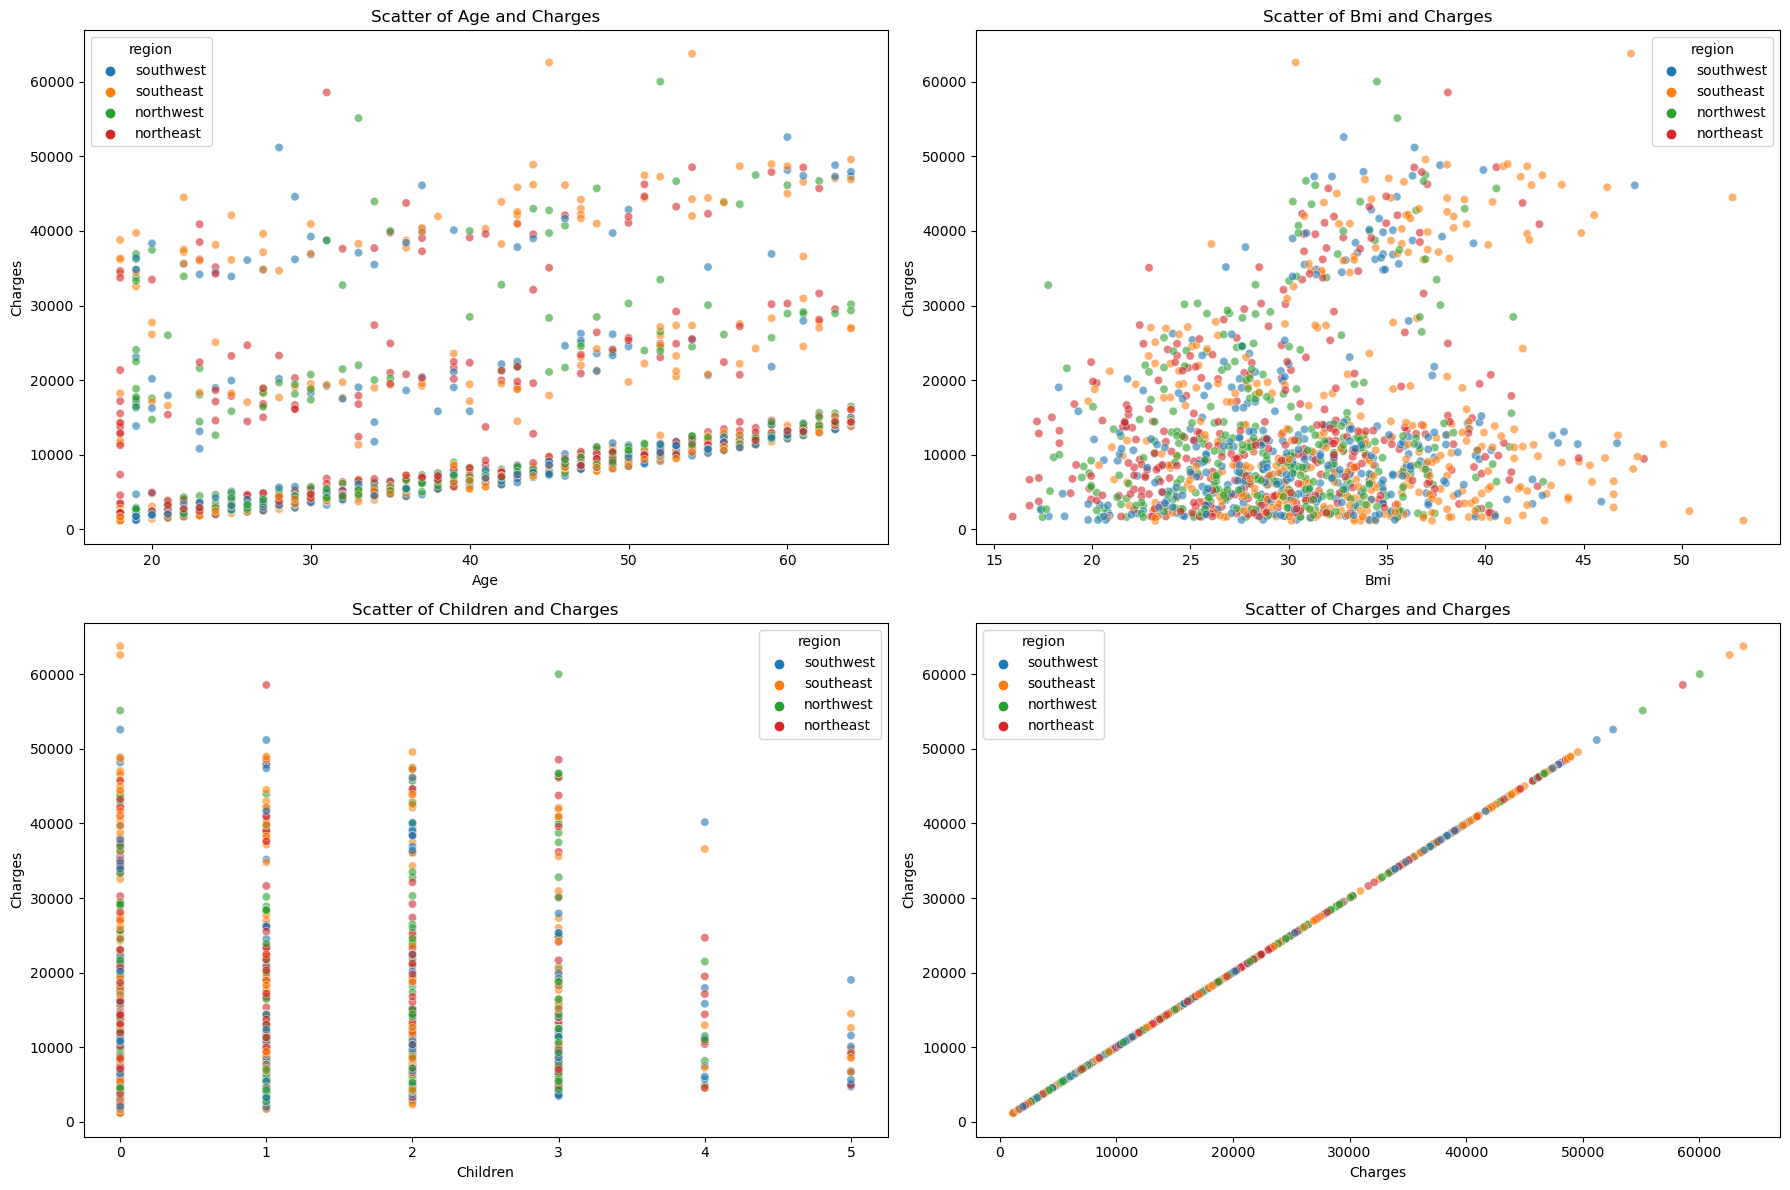

In [50]:
fig = plt.figure(figsize = (18,12))
for i, column in enumerate(num_columns):
    ax = fig.add_subplot(2,2,i+1)
    sns.scatterplot(insurance[column], insurance['charges'],
              hue = insurance['region'], alpha = 0.6)
    plt.xlabel(f"{column.title()}")
    plt.ylabel('Charges')
    plt.title(f"Scatter of {column.title()} and Charges")
plt.tight_layout()
plt.show()

A bit inconclusive, maybe there's a thought that patients in the northwest have lower charges..

In [51]:
for i in cat_columns:
    print(insurance[i].value_counts(),'\n')

male      676
female    662
Name: sex, dtype: int64 

no     1064
yes     274
Name: smoker, dtype: int64 

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64 



The categorical representations are balanced besides smokers, as 1/6 of the patients are smokers. 

### Boxplots
Now let's isolate the categorical columns

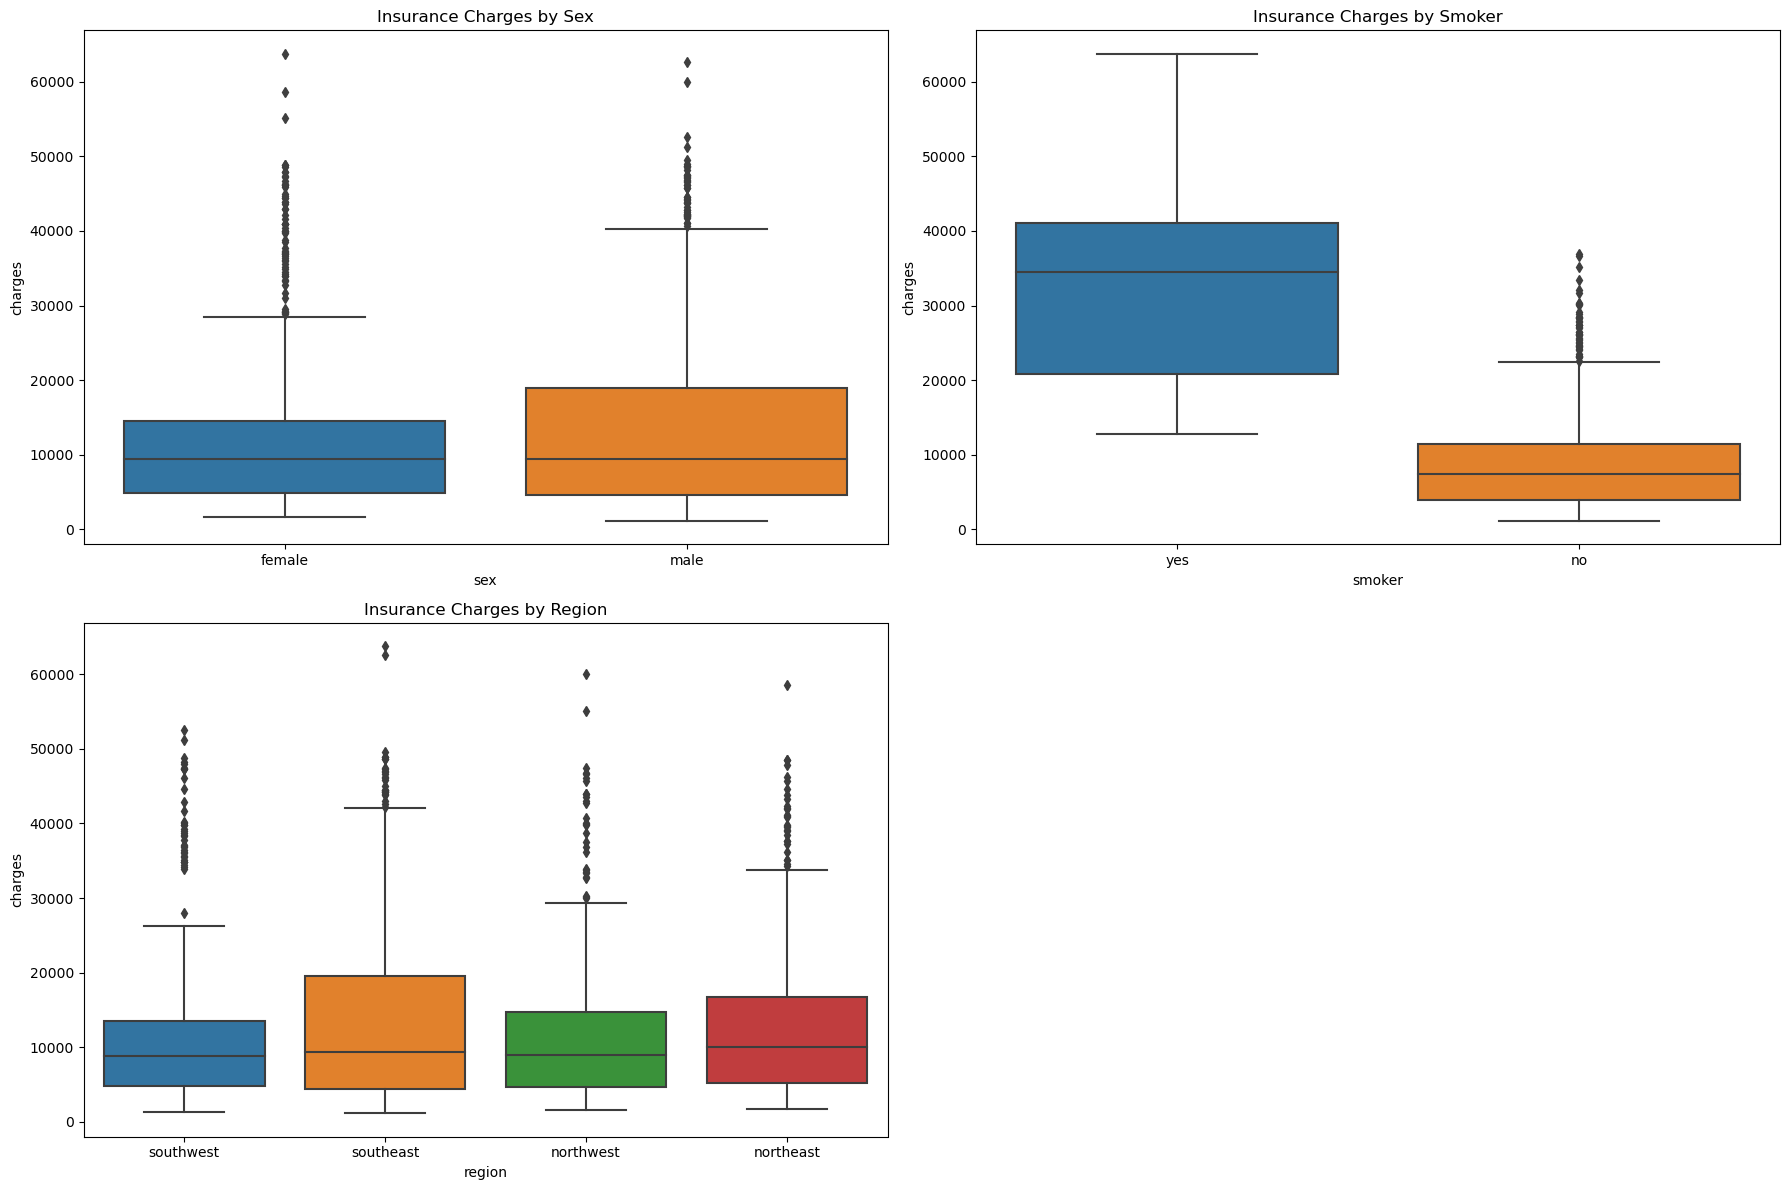

In [52]:
fig = plt.figure(figsize = (18,12))
for i, column in enumerate(cat_columns):
    ax = fig.add_subplot(2,2,i+1)
    sns.boxplot(insurance[column], insurance['charges'])
    plt.title(f"Insurance Charges by {column.title()}")
plt.tight_layout()
plt.show()

So there is some case to be made about males having higher charges, even if only slightly. Smokers we see a clear affirmation of what we already stated. And possibly southeast has the highest amount of insurance charge and patients in the southwest have the lowest? 

It seems that for predicting variables it's clear we need to have presence of smoking in the model. Age could also be added, as we saw a clear rise in prices along with the patient age. BMI I don't think there's much of a relationship which is surprising. Children is a bit hard to analyze as well. 

Let's transform our categorical variables and create a correlative figure to firmly identify what variables we want to include. 

In [53]:
insurance['sex'] = insurance['sex'].map({'male' : 1, 'female' :0})
insurance['smoker'] = insurance['smoker'].map({'yes' : 1, 'no' :0})
#Converting to binary
insurance['region'] = insurance['region'].map(
    {'southwest' : 1, 'southeast' : 2, 'northwest' : 3, 'northeast' : 4})

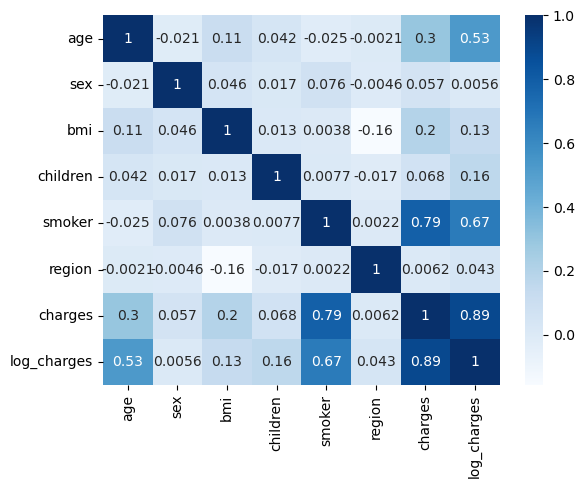

In [73]:
correlations = insurance.corr()
sns.heatmap(correlations, cmap = "Blues", annot = True)
plt.show()

We see smoker, age and bmi to be the top correlative factors with charges. 
There is also a potential relationship to explore between region and bmi. Let's look at that quickly. 

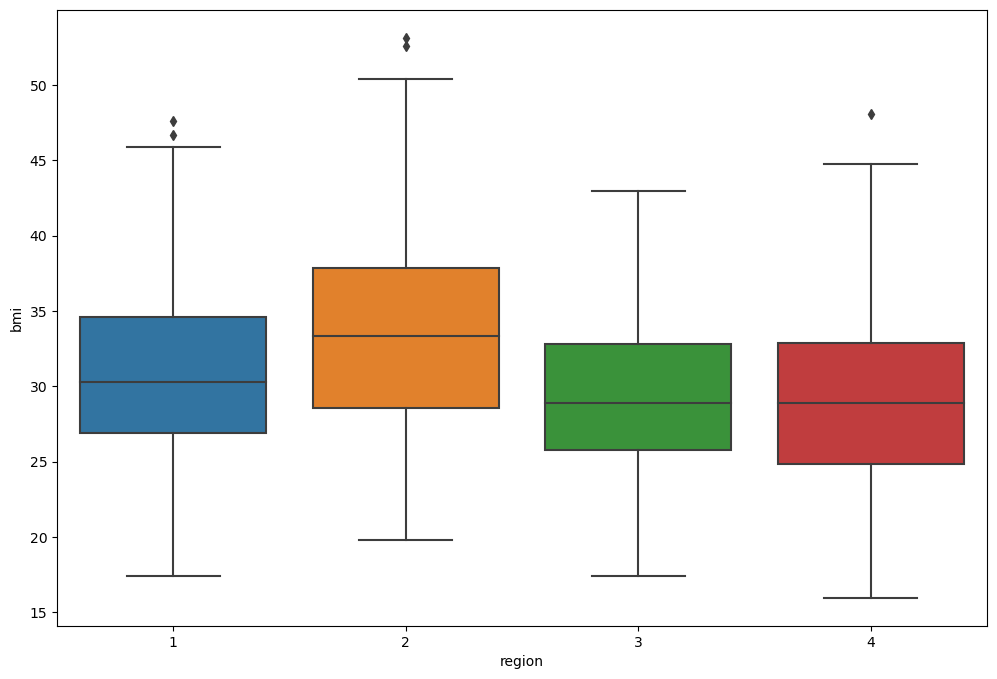

In [55]:
fig = plt.figure(figsize = (12,8))
sns.boxplot(insurance['region'], insurance['bmi'])
plt.show()

Perhaps there is a relationship here, especially for region 2. But for now let's not include it in the model and see how it goes. 

#### Key Features
- smoker
- age
- bmi

## Splitting Data

In [56]:
X = insurance.drop('charges', axis = 1) #Drop the target feature
y = insurance['charges']

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 1) #Split data

## Model Building

In [58]:
X_train_subset = X_train[['age','bmi','smoker']] #Using our key features
X_test_subset = X_test[['age','bmi','smoker']]

In [59]:
model = LinearRegression() #Creating model

In [60]:
model.fit(X_train_subset, y_train) #Fitting model

LinearRegression()

In [61]:
train_predictions = model.predict(X_train_subset)
test_predictions = model.predict(X_test_subset)

In [62]:
print(f"Model Coefficients: {model.coef_}\n Model Intercept: {model.intercept_}")

Model Coefficients: [  258.96243109   303.37204687 23723.48386217]
 Model Intercept: -11052.767949478224


These coefficients make sense with the correlation numbers we saw earlier. The 3rd coefficient, that representing the "smoker" variable, is the highest of the three. 
- 259: An increase in age leads to a 259 increase in the insurance charge on a patient with other variables held constant. 
- 303: Higher bmi will give a 303 increase in insurance charges a patient will be billed if other variables are held constant. 
- 23,723: Smoking will give a ~$20,000 increase in billing as a result of the health issues that pair with the activity, if all other variables are held constant. 

In [63]:
residuals = y_train - train_predictions

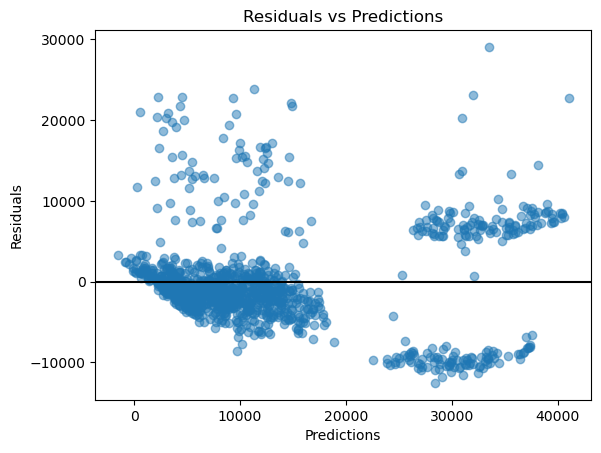

In [64]:
plt.scatter(train_predictions, residuals, alpha = 0.5) #Examining residuals vs predictions
plt.axhline(0, color = 'black')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.title('Residuals vs Predictions')
plt.show()

We want these values to be around zero, meaning there is no difference between our predictions and the rest of the value from our training set (the residual). Our plot does that a little, but there are some stray values and they aren't very consistent in their magnitude away from the line.

In [68]:
score = r2_score(y_train, train_predictions)
mse = mean_squared_error(y_train, train_predictions)
rmse = mean_squared_error(y_train, train_predictions, squared = False)

print(f"R2 Model Score: {score}\n Mean Squared Error: {mse}\n Root Mean Squared Error: {rmse}")

R2 Model Score: 0.7449386448927938
 Mean Squared Error: 37200424.786834076
 Root Mean Squared Error: 6099.215095963912


So the R2 isn't too bad, ~0.75 is better than I've seen before. But the errors are quite large. 

## Judging against Test Data

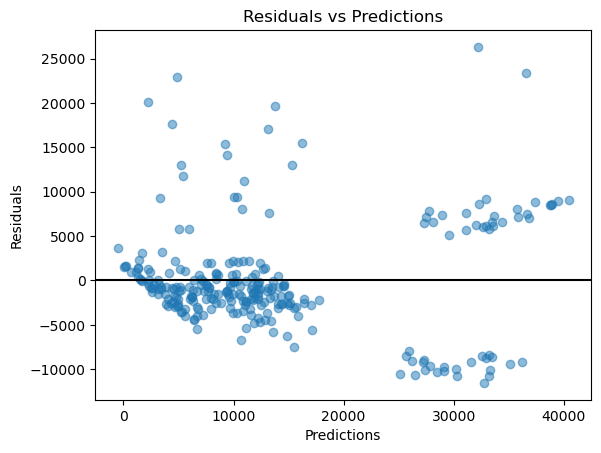

In [79]:
residuals = y_test - test_predictions
plt.scatter(test_predictions, residuals, alpha = 0.5)
plt.axhline(0, color = 'black')
plt.ylabel('Residuals')
plt.xlabel('Predictions')
plt.title('Residuals vs Predictions')
plt.show()

In [71]:
score = r2_score(y_test, test_predictions)
mse = mean_squared_error(y_test, test_predictions)
rmse = mean_squared_error(y_test, test_predictions, squared = False)

print(f"R2 Model Score: {score}\n Mean Squared Error: {mse}\n Root Mean Squared Error: {rmse}")

R2 Model Score: 0.7567968214396313
 Mean Squared Error: 36305526.05071479
 Root Mean Squared Error: 6025.406712473009


Very similar

# Conclusion
Our model could explain ~75% of the variance in the insurance charges, for both training and test data. Also our error was both around 6000 for either. One reason the error was so high is because I didn't normalize the data. The values ranged from zero to 60,000, so of course there is going to be high variability and error within the model. 

**But**, our variance and error was around the same for either set of data, which means the model fit quite well. The residual plots show that predictions of higher insurance charges are less accurate (both above and below the actual amount). 